# PyTorch 3DCNN Classfication (Subject Base data Splitting)
This notebook using PyTorch and cudaGPU.

In [1]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"decive: {device}")

decive: cuda


# 讀取數據

In [3]:
csv_path = 'structured_data_mac.csv'
df = pd.read_csv(csv_path)

# 檢查並清理數據

In [4]:
if df['Group'].isnull().any():
    df = df.dropna(subset=['Group'])

# 檢查是否存在非預期的標籤值

In [5]:
expected_labels = ['CN', 'MCI', 'AD']
df = df[df['Group'].isin(expected_labels)]

image_paths = df['Image Path'].tolist()

# 將標籤映射為數字

In [6]:
label_mapping = {'CN': 0, 'MCI': 1, 'AD': 2}
labels = df['Group'].map(label_mapping).tolist()

# 獲取個別的病人ID

In [7]:
unique_patients = df['Subject'].unique()

# 根據病人ID進行訓練和驗證分割

In [8]:
train_ids, val_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)

# 創建訓練和驗證DataFrame

In [9]:
train_df = df[df['Subject'].isin(train_ids)]
val_df = df[df['Subject'].isin(val_ids)]

# 提取訓練和驗證影像路徑和標籤

In [10]:
train_paths = train_df['Image Path'].tolist()
train_labels = train_df['Group'].map(label_mapping).tolist()
val_paths = val_df['Image Path'].tolist()
val_labels = val_df['Group'].map(label_mapping).tolist()

# 將標籤轉換為 tensor

In [11]:
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

In [12]:
# Define the PyTorch dataset class
class NiftiDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        nifti_path = self.image_paths[idx]
        label = self.labels[idx]
        nifti_image = nib.load(nifti_path)
        image = nifti_image.get_fdata()
        image = np.resize(image, (96, 96, 96))
        image = torch.tensor(image, dtype=torch.float32)
        image = image.unsqueeze(0)  # Add channel dimension
        return image, label

In [13]:
# Create dataset instances
train_dataset = NiftiDataset(train_paths, train_labels_tensor)
val_dataset = NiftiDataset(val_paths, val_labels_tensor)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 3D CNN 模型架構定義
## 模型組件

1. **卷積層（Convolutional Layers）**：
    - 第一層：使用16個3x3x3的過濾器。
    - 第二層：使用32個3x3x3的過濾器。

2. **池化層（Pooling Layers）**：
    - 每個卷積層後面跟著的最大池化層，使用2x2x2的池化窗口。

3. **批量歸一化層（Batch Normalization Layers）**：
    - 在每個池化層之後進行批量歸一化，有助於模型學習過程中的穩定性和效率。

4. **全局平均池化層（Global Average Pooling Layer）**：
    - 對特徵圖進行全局平均池化，將每個特徵通道的空間維度縮減為單一數值。

5. **全連接層（Dense Layers）**：
    - 第一層：32個輸入特徵映射到64個神經元。
    - Dropout層：在全連接層後添加，dropout比例設為0.3，以減少訓練過程中的過擬合。

6. **輸出層（Output Layer）**：
    - 將64個神經元的輸出映射到3個輸出單元，對應於3個不同類別的預測。

In [14]:
class Conv3DNet(nn.Module):
    def __init__(self, width, height, depth):
        super(Conv3DNet, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3)
        self.pool1 = nn.MaxPool3d(kernel_size=2)  # Corrected keyword argument here
        self.bn1 = nn.BatchNorm3d(num_features=16)

        # Convolutional Layer 2
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3)
        self.pool2 = nn.MaxPool3d(kernel_size=2)  # Corrected keyword argument here
        self.bn2 = nn.BatchNorm3d(num_features=32)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)

        # Dense Layer
        self.fc1 = nn.Linear(in_features=32, out_features=64)
        self.dropout = nn.Dropout(0.3)

        # Output Layer
        self.fc2 = nn.Linear(in_features=64, out_features=3)

    def forward(self, x):
        # Apply first convolutional block
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)
        x = self.bn1(x)

        # Apply second convolutional block
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        x = self.bn2(x)

        # Apply global average pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor

        # Apply dense layer with dropout
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        # Output layer
        x = self.fc2(x)
        return nn.Softmax(dim=1)(x)

In [15]:
model = Conv3DNet(96, 96, 96).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練與驗證 3D CNN 模型

此代碼塊主要用於訓練和驗證一個三維卷積神經網路（3D CNN）模型。模型被訓練來處理醫學影像數據，並在20個週期（epochs）內進行迭代訓練和驗證。

## 訓練過程

- 每個週期開始時，模型設定為訓練模式。
- 數據被加載並分批（通過 `train_loader`）傳遞到模型中。
- 對於每一批數據，模型首先在GPU上進行計算（`.to('cuda')`），然後進行前向傳播，計算損失，並進行反向傳播更新模型參數。
- 訓練損失被累加，用於後續計算整個週期的平均訓練損失。
- 同時，模型預測和真實目標被收集，用於計算訓練準確度和F1分數。

## 驗證過程

- 在每個訓練週期後，模型切換到評估模式。
- 使用不參與訓練的驗證數據集（通過 `val_loader` 加載）來評估模型的性能。
- 在這個階段，不進行梯度計算（`torch.no_grad()`），以減少內存使用並加速處理。
- 驗證損失、驗證準確度和驗證F1分數被計算，以評估模型在未見數據上的表現。

## 保存模型和早期停止

- 如果在某個週期的驗證損失比之前所有週期都低，或者驗證準確度有提高，則保存該模型。
- 兩種不同的保存策略：一種基於最低驗證損失（`Subject_based_Splitting_3DCNN_pytorch_model_min_loss.pth`），另一種基於最高驗證準確度（`Subject_based_Splitting_3DCNN_pytorch_model_max_accuracy.pth`）。
- 如果連續多個週期沒有改善（在這個例子中是超過3個週期），則實行早期停止，以防止過擬合。

## 性能輸出

- 每個週期結束時，打印訓練和驗證損失，以及準確度和F1分數，以便於追蹤模型的學習進度和性能。



Validation Epoch 1/20: 100%|██████████| 11/11 [00:42<00:00,  3.91s/it]


Epoch 1, Train Loss: 1.0822599142789842, Validation Loss: 1.0647034211592241
Training Accuracy: 0.4474616292798111, Training F1: 0.40790436656339996
Validation Accuracy: 0.6298600311041991, Validation F1: 0.488021321809742


Validation Epoch 2/20: 100%|██████████| 11/11 [00:46<00:00,  4.21s/it]


Epoch 2, Train Loss: 1.0416441559791565, Validation Loss: 0.943660708990964
Training Accuracy: 0.5080676898858717, Training F1: 0.38242492315461174
Validation Accuracy: 0.6220839813374806, Validation F1: 0.4869732031137725


Validation Epoch 3/20: 100%|██████████| 11/11 [00:53<00:00,  4.86s/it]


Epoch 3, Train Loss: 1.0100357249379157, Validation Loss: 0.9156421314586293
Training Accuracy: 0.5245966155057065, Training F1: 0.41967920050872815
Validation Accuracy: 0.6314152410575428, Validation F1: 0.48875993874044293


Validation Epoch 4/20: 100%|██████████| 11/11 [00:54<00:00,  4.96s/it]


Epoch 4, Train Loss: 0.9990682020783425, Validation Loss: 0.9115889505906538
Training Accuracy: 0.5360094451003542, Training F1: 0.4627480729050594
Validation Accuracy: 0.5956454121306376, Validation F1: 0.5054630820590688


Validation Epoch 5/20: 100%|██████████| 11/11 [00:53<00:00,  4.85s/it]


Epoch 5, Train Loss: 0.9916991382837296, Validation Loss: 0.8946336074308916
Training Accuracy: 0.5434868162140889, Training F1: 0.4771967264912916
Validation Accuracy: 0.6220839813374806, Validation F1: 0.4843069921821996


Validation Epoch 6/20: 100%|██████████| 11/11 [00:53<00:00,  4.84s/it]


Epoch 6, Train Loss: 0.9860999554395675, Validation Loss: 0.9193185676227916
Training Accuracy: 0.5442739079102715, Training F1: 0.47902816426825834
Validation Accuracy: 0.6314152410575428, Validation F1: 0.48875993874044293


Validation Epoch 7/20: 100%|██████████| 11/11 [00:51<00:00,  4.71s/it]


Epoch 7, Train Loss: 0.9852770805358887, Validation Loss: 0.8929165005683899
Training Accuracy: 0.5533254624163715, Training F1: 0.48786886702307986
Validation Accuracy: 0.6220839813374806, Validation F1: 0.4843069921821996


Validation Epoch 8/20: 100%|██████████| 11/11 [01:43<00:00,  9.45s/it]


Epoch 8, Train Loss: 0.9846717834472656, Validation Loss: 0.9045747030865062
Training Accuracy: 0.5501770956316411, Training F1: 0.4845310851521382
Validation Accuracy: 0.6314152410575428, Validation F1: 0.48875993874044293


Validation Epoch 9/20: 100%|██████████| 11/11 [01:42<00:00,  9.32s/it]


Epoch 9, Train Loss: 0.9803782448172569, Validation Loss: 1.1166566285220059
Training Accuracy: 0.5450609996064542, Training F1: 0.48196068689622656
Validation Accuracy: 0.3701399688958009, Validation F1: 0.34235850342236024
Stopping early due to no improvement in validation loss.


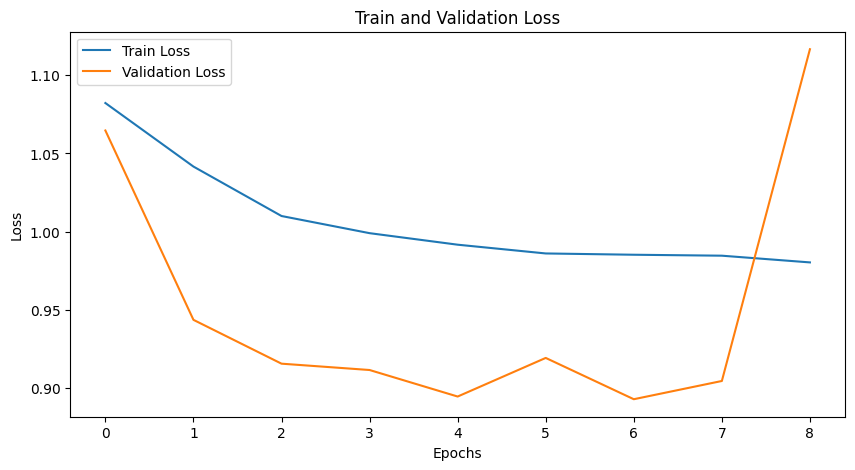

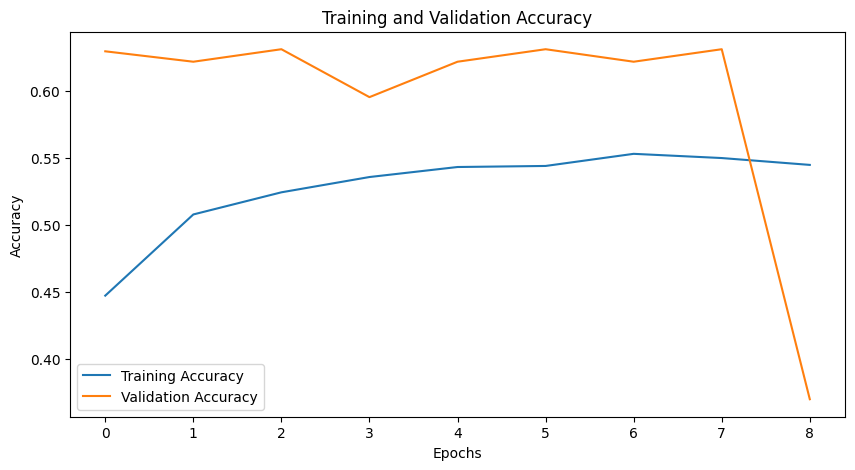

In [16]:
epochs = 20
best_val_loss = float('inf')
patience = 0
best_val_accuracy = 0.0

# 初始化用於繪圖的列表
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # 訓練階段
    model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_targets = []
    for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        images = images.to('cuda')
        targets = targets.to('cuda')
        optimizer.zero_grad()
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # 收集預測和目標
        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_targets.extend(targets.cpu().numpy())

    # 驗證階段
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
            images = images.to('cuda')
            targets = targets.to('cuda')
            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs, targets)
            val_loss += loss.item()

            # 收集預測和目標
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_targets.extend(targets.cpu().numpy())

    # 計算準確度和 F1 分數
    train_accuracy = accuracy_score(all_train_targets, all_train_preds)
    train_f1 = f1_score(all_train_targets, all_train_preds, average='weighted')
    val_accuracy = accuracy_score(all_val_targets, all_val_preds)
    val_f1 = f1_score(all_val_targets, all_val_preds, average='weighted')

    # 計算並儲存每次迭代的損失和準確率
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")
    print(f"Training Accuracy: {train_accuracy}, Training F1: {train_f1}")
    print(f"Validation Accuracy: {val_accuracy}, Validation F1: {val_f1}")

    # 保存模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Subject_based_Splitting_3DCNN_pytorch_model_min_loss.pth')
        patience = 0
    else:
        patience += 1

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'Subject_based_Splitting_3DCNN_pytorch_model_max_accuracy.pth')
        patience = 0
    else:
        patience += 1

    # 早期停止
    if patience > 3:
        print("Stopping early due to no improvement in validation loss.")
        break

# 繪製損失圖
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製準確率圖
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()